### Created by: Anthony D. Cho
### Last update: 27.11.2021

**Subject**: Classification (CNN - keras, tensorflow) - Flowers Recognition

In [1]:
## Librerias generales
import os
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from glob import glob
from numpy import zeros, array, argmax, vstack

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Keras tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

### Customized function

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

**Data source:**

[Flowers classification](https://www.kaggle.com/alxmamaev/flowers-recognition) (Classification)

In [3]:
if not os.path.exists("dataFlowers.zip"):
    ## Download files

    !wget https://github.com/adoc-box/Datasets/blob/main/flowers.zip?raw=true
    !wget https://github.com/adoc-box/Datasets/blob/main/flowers.z01?raw=true

    !mv flowers.zip\?raw\=true flowers.zip
    !mv flowers.z01\?raw\=true flowers.z01

    ## join files 
    !zip -F flowers.zip --out dataFlowers.zip

    ## remove some files
    !rm flowers.z01 flowers.zip

    ## un-compress joined zip file
    !unzip dataFlowers.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 copying: data/train/rose/3576488381_611f3446e0_n.jpg
 copying: data/train/rose/3624546109_8eb98f0cdb.jpg
 copying: data/train/rose/3634244527_e72c47842c_n.jpg
 copying: data/train/rose/3654988152_b11178bbcb.jpg
 copying: data/train/rose/3655527028_0fab2b547d_n.jpg
 copying: data/train/rose/3661675690_ed2d05fa5f_n.jpg
 copying: data/train/rose/3664842094_5fd60ee26b.jpg
 copying: data/train/rose/3667366832_7a8017c528_n.jpg
 copying: data/train/rose/3873271620_1d9d314f01_n.jpg
 copying: data/train/rose/3909587261_f8cd3e7fe7.jpg
 copying: data/train/rose/394990940_7af082cf8d_n.jpg
 copying: data/train/rose/4061451210_1650590c6a.jpg
 copying: data/train/rose/4093390305_4010c736c9.jpg
 copying: data/train/rose/410421672_563550467c.jpg
 copying: data/train/rose/410425647_4586667858.jpg
 copying: data/train/rose/4242976586_607a8f9843_n.jpg
 copying: data/train/rose/4279989256_9a48c0d194_n.jpg
 copying: data/train/rose/42799908

### Image loader generator

In [4]:
## Images PATHs
train_dir = 'data/train/'
validation_dir = 'data/validation/'
test_dir = 'data/test/'

## Image generator instances
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Image conversion size
imgSize = 150

## Generator setting (Train)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to (imgSize x imgSize)
        target_size=(imgSize, imgSize), ## 224
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

## Generator setting (Validation)
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

## Generator setting (test)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

Found 2313 images belonging to 5 classes.
Found 554 images belonging to 5 classes.
Found 380 images belonging to 5 classes.


### Model building

In [5]:
## Model instance

model = Sequential(name='FlowersRecognition')
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu',
                        input_shape=(150, 150, 3),
                        name='Conv2D_01'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              name='Pooling_01'))
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='relu',
                        name='Conv2D_02'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              name='Pooling_02'))
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu',
                        name='Conv2D_03'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              name='Pooling_03'))
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu',
                        name='Conv2D_04'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              name='Pooling_04'))
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(units=512, 
                       activation='relu',
                       name='Dense_01'))
model.add(layers.Dense(units=5, 
                       activation='softmax',
                       name='output'))

model.summary()

Model: "FlowersRecognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 Pooling_01 (MaxPooling2D)   (None, 74, 74, 32)        0         
                                                                 
 Conv2D_02 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 Pooling_02 (MaxPooling2D)   (None, 36, 36, 64)        0         
                                                                 
 Conv2D_03 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 Pooling_03 (MaxPooling2D)   (None, 17, 17, 128)       0         
                                                                 
 Conv2D_04 (Conv2D)          (None, 15, 15, 128)

In [6]:
start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

## Model fitting
history = model.fit(
      train_generator, 
      steps_per_epoch=115,  ## <- 2312 images / batch size of 20 approx 115
      validation_data=validation_generator,
      validation_steps=27,  ## <- 554 images / batch size of 20 approx 27
      epochs=30, verbose=1)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

model.save('ConvNet_simple.h5')

Epoch 1/30
115/115 [==============================] - 19s 89ms/step - loss: 1.4124 - acc: 0.3589 - val_loss: 1.2318 - val_acc: 0.4481
Epoch 2/30
115/115 [==============================] - 10s 86ms/step - loss: 1.1621 - acc: 0.5137 - val_loss: 1.1591 - val_acc: 0.5204
Epoch 3/30
115/115 [==============================] - 10s 85ms/step - loss: 1.0650 - acc: 0.5661 - val_loss: 1.1168 - val_acc: 0.5593
Epoch 4/30
115/115 [==============================] - 10s 85ms/step - loss: 0.9908 - acc: 0.6123 - val_loss: 1.0528 - val_acc: 0.5815
Epoch 5/30
115/115 [==============================] - 11s 93ms/step - loss: 0.9299 - acc: 0.6393 - val_loss: 1.0570 - val_acc: 0.5778
Epoch 6/30
115/115 [==============================] - 10s 84ms/step - loss: 0.8597 - acc: 0.6690 - val_loss: 0.9965 - val_acc: 0.6037
Epoch 7/30
115/115 [==============================] - 10s 84ms/step - loss: 0.8031 - acc: 0.6921 - val_loss: 0.9476 - val_acc: 0.6463
Epoch 8/30
115/115 [==============================] - 10s 84ms

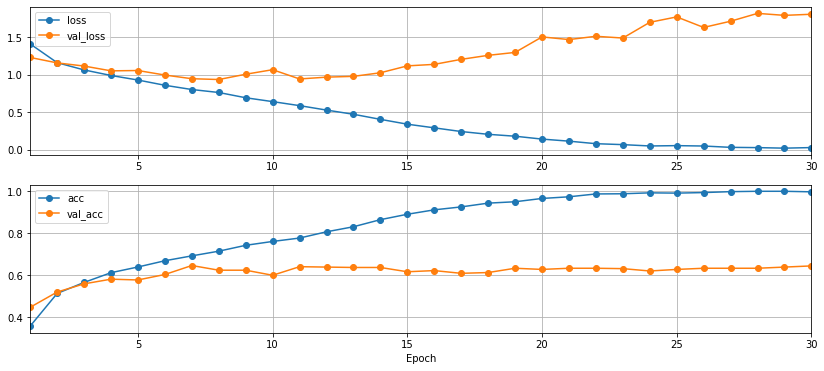

19/19 [==============================] - 1s 63ms/step - loss: 1.6556 - acc: 0.6342
[1.6556180715560913, 0.6342105269432068]


In [7]:
## display performances
plot_history(history, width=14)

## restart test generator index
test_generator.reset()

## evaluate test set in the model
print(model.evaluate(test_generator, 
                     steps=19))  ## <- 380 images / batch size of 20 equal 19

## restart test generator index
test_generator.reset()

## Compute prediction using test generator
prediction = model.predict(test_generator, steps=19)

In [8]:
## restart test generator index
test_generator.reset()

## labels allocation
i, y_true = 0, []
for _, y in test_generator:
    y_true.append(y)
    i+=1
    if i == 19:
      break
y_true = vstack(y_true)

## Decoding labels
y_true = argmax(y_true, axis=1)
prediction_decoded = argmax(prediction, axis=1)

In [9]:
y_true.shape, prediction_decoded.shape

((380,), (380,))

In [10]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[40 11  6  4  9]
 [ 7 62  1 10 10]
 [ 7  3 29  2 29]
 [ 1  2  1 59  8]
 [ 5  9  9  5 51]]
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        70
           1       0.71      0.69      0.70        90
           2       0.63      0.41      0.50        70
           3       0.74      0.83      0.78        71
           4       0.48      0.65      0.55        79

    accuracy                           0.63       380
   macro avg       0.64      0.63      0.63       380
weighted avg       0.64      0.63      0.63       380



## Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 11.

In [11]:
## Restart all generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

In [12]:
## Model instance

model = Sequential(name='FlowersRecognition')
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu',
                        input_shape=(150, 150, 3),
                        name='Conv2D_01'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              name='Pooling_01'))
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='relu',
                        name='Conv2D_02'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              name='Pooling_02'))
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu',
                        name='Conv2D_03'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              name='Pooling_03'))
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3), 
                        activation='relu',
                        name='Conv2D_04'))
model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              name='Pooling_04'))
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(units=512, 
                       activation='relu',
                       name='Dense_01'))
model.add(layers.Dense(units=5, 
                       activation='softmax',
                       name='output'))

model.summary()

Model: "FlowersRecognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 Pooling_01 (MaxPooling2D)   (None, 74, 74, 32)        0         
                                                                 
 Conv2D_02 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 Pooling_02 (MaxPooling2D)   (None, 36, 36, 64)        0         
                                                                 
 Conv2D_03 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 Pooling_03 (MaxPooling2D)   (None, 17, 17, 128)       0         
                                                                 
 Conv2D_04 (Conv2D)          (None, 15, 15, 128)

In [13]:
start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

## Model fitting
history = model.fit(
      train_generator, 
      steps_per_epoch=115,  ## <- 2312 images / batch size of 20 approx 115
      epochs=11, verbose=1)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

model.save('ConvNet_simple.h5')

Epoch 1/11
115/115 [==============================] - 9s 72ms/step - loss: 1.3949 - acc: 0.3803
Epoch 2/11
115/115 [==============================] - 8s 71ms/step - loss: 1.1265 - acc: 0.5325
Epoch 3/11
115/115 [==============================] - 8s 72ms/step - loss: 1.0573 - acc: 0.5726
Epoch 4/11
115/115 [==============================] - 8s 70ms/step - loss: 0.9914 - acc: 0.6101
Epoch 5/11
115/115 [==============================] - 8s 72ms/step - loss: 0.9125 - acc: 0.6433
Epoch 6/11
115/115 [==============================] - 8s 71ms/step - loss: 0.8540 - acc: 0.6720
Epoch 7/11
115/115 [==============================] - 8s 72ms/step - loss: 0.8231 - acc: 0.6838
Epoch 8/11
115/115 [==============================] - 8s 72ms/step - loss: 0.7820 - acc: 0.7048
Epoch 9/11
115/115 [==============================] - 8s 71ms/step - loss: 0.7269 - acc: 0.7292
Epoch 10/11
115/115 [==============================] - 9s 74ms/step - loss: 0.6632 - acc: 0.7549
Epoch 11/11
115/115 [==================

In [14]:
## restart test generator index
test_generator.reset()

## evaluate test set in the model
print(model.evaluate(test_generator, 
                     steps=19))  ## <- 380 images / batch size of 20 equal 19

## restart test generator index
test_generator.reset()

## Compute prediction using test generator
prediction = model.predict(test_generator, steps=19)

19/19 [==============================] - 1s 65ms/step - loss: 0.8840 - acc: 0.6684
[0.8840466141700745, 0.6684210300445557]


In [15]:
## restart test generator index
test_generator.reset()

## labels allocation
i, y_true = 0, []
for _, y in test_generator:
    y_true.append(y)
    i+=1
    if i == 19:
      break
y_true = vstack(y_true)

## Decoding labels
y_true = argmax(y_true, axis=1)
prediction_decoded = argmax(prediction, axis=1)

In [16]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[43  4  3  5 15]
 [ 5 62  1  9 13]
 [ 3  3 20  0 44]
 [ 0  4  0 58  9]
 [ 2  3  1  2 71]]
              precision    recall  f1-score   support

           0       0.81      0.61      0.70        70
           1       0.82      0.69      0.75        90
           2       0.80      0.29      0.42        70
           3       0.78      0.82      0.80        71
           4       0.47      0.90      0.61        79

    accuracy                           0.67       380
   macro avg       0.74      0.66      0.66       380
weighted avg       0.73      0.67      0.66       380

